## 5 - Modeling Industry Specific
> Explain Step

### 5.0 - Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn-whitegrid')

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

### 5.1 - Read in Data

In [6]:
df = pd.read_csv('../clean_data/modeling2.csv')

In [7]:
df.head(1)

,company,security,gics_sector,gics_sub_industry,release_date,length_corpus,items,stock_change,index_change,normalized_change,vix,hist_week,hist_month,hist_quarter,hist_year,movement,processed_text
0,CSCO,Cisco Systems,Information Technology,Communications Equipment,2019-08-22 16:35:32,337,['Item8.01'],-0.005812,-0.004064,-0.001747,16.68,0.054486,-0.138644,-0.089602,0.059757,neutral,form 8-k united state security exchange commis...


In [8]:
df.shape

(56911, 17)

### 5.2 - Create numerical `Target` Column

In [9]:
df['target'] = df['movement'].map(lambda x: 2 if x == 'up' else (1 if x == 'neutral' else 0))

### 5.3 - Multi Label Binarizer `Items` Column

In [10]:
import ast
def eval_literal(list_words):
    try:
        return ast.literal_eval(list_words)  
    except ValueError:
        return ast.literal_eval(str(list_words))  

In [11]:
# Items from list of strings to literal - ''
df['items'] = df['items'].progress_map(eval_literal)

In [12]:
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df['items']), columns=mlb.classes_,), sort=False, how="left")

In [13]:
df.drop(columns=['items'], inplace=True)

### 5.4 - Get Dummies and `gics_sub_industry`

In [14]:
df = pd.get_dummies(df, columns=['gics_sub_industry'], drop_first=True)

In [15]:
df.head(1)

,company,security,gics_sector,release_date,length_corpus,stock_change,index_change,normalized_change,vix,hist_week,hist_month,hist_quarter,hist_year,movement,processed_text,target,Item0.06,Item05.07,Item1.01,Item1.02,Item1.03,Item1.04,Item2.01,Item2.02,Item2.03,Item2.04,Item2.05,Item2.06,Item3.01,Item3.02,Item3.03,Item3.04,Item3.05,Item4.01,Item4.02,Item4.04,Item5.01,Item5.02,Item5.03,Item5.04,Item5.05,Item5.07,Item5.08,Item5.10,Item6.01,Item6.10,Item6.19,Item7.01,Item8.01,Item9.01,Item9.02,gics_sub_industry_Aerospace & Defense,gics_sub_industry_Agricultural & Farm Machinery,gics_sub_industry_Agricultural Products,gics_sub_industry_Air Freight & Logistics,gics_sub_industry_Airlines,gics_sub_industry_Apparel Retail,"gics_sub_industry_Apparel, Accessories & Luxury Goods",gics_sub_industry_Application Software,gics_sub_industry_Asset Management & Custody Banks,gics_sub_industry_Auto Parts & Equipment,gics_sub_industry_Automobile Manufacturers,gics_sub_industry_Automotive Retail,gics_sub_industry_Biotechnology,gics_sub_industry_Brewers,gics_sub_industry_Broadcasting,gics_sub_industry_Building Products,gics_sub_industry_Cable & Satellite,gics_sub_industry_Casinos & Gaming,gics_sub_industry_Communications Equipment,gics_sub_industry_Computer & Electronics Retail,gics_sub_industry_Construction & Engineering,gics_sub_industry_Construction Machinery & Heavy Trucks,gics_sub_industry_Construction Materials,gics_sub_industry_Consumer Electronics,gics_sub_industry_Consumer Finance,gics_sub_industry_Copper,gics_sub_industry_Data Processing & Outsourced Services,gics_sub_industry_Department Stores,gics_sub_industry_Distillers & Vintners,gics_sub_industry_Distributors,gics_sub_industry_Diversified Banks,gics_sub_industry_Diversified Chemicals,gics_sub_industry_Diversified Support Services,gics_sub_industry_Drug Retail,gics_sub_industry_Electric Utilities,gics_sub_industry_Electrical Components & Equipment,gics_sub_industry_Electronic Components,gics_sub_industry_Electronic Equipment & Instruments,gics_sub_industry_Electronic Manufacturing Services,gics_sub_industry_Environmental & Facilities Services,gics_sub_industry_Fertilizers & Agricultural Chemicals,gics_sub_industry_Financial Exchanges & Data,gics_sub_industry_Food Distributors,gics_sub_industry_Food Retail,gics_sub_industry_Gas Utilities,gics_sub_industry_General Merchandise Stores,gics_sub_industry_Gold,gics_sub_industry_Health Care Distributors,gics_sub_industry_Health Care Equipment,gics_sub_industry_Health Care Facilities,gics_sub_industry_Health Care REITs,gics_sub_industry_Health Care Services,gics_sub_industry_Health Care Supplies,gics_sub_industry_Health Care Technology,gics_sub_industry_Home Furnishings,gics_sub_industry_Home Improvement Retail,gics_sub_industry_Homebuilding,gics_sub_industry_Hotel & Resort REITs,"gics_sub_industry_Hotels, Resorts & Cruise Lines",gics_sub_industry_Household Appliances,gics_sub_industry_Household Products,gics_sub_industry_Housewares & Specialties,gics_sub_industry_Human Resource & Employment Services,gics_sub_industry_Hypermarkets & Super Centers,gics_sub_industry_IT Consulting & Other Services,gics_sub_industry_Independent Power Producers & Energy Traders,gics_sub_industry_Industrial Conglomerates,gics_sub_industry_Industrial Gases,gics_sub_industry_Industrial Machinery,gics_sub_industry_Industrial REITs,gics_sub_industry_Insurance Brokers,gics_sub_industry_Integrated Oil & Gas,gics_sub_industry_Integrated Telecommunication Services,gics_sub_industry_Interactive Home Entertainment,gics_sub_industry_Interactive Media & Services,gics_sub_industry_Internet & Direct Marketing Retail,gics_sub_industry_Internet Services & Infrastructure,gics_sub_industry_Investment Banking & Brokerage,gics_sub_industry_Leisure Products,gics_sub_industry_Life & Health Insurance,gics_sub_industry_Life Sciences Tools & Services,gics_sub_industry_Managed Health Care,gics_sub_industry_Metal & Glass Containers,gics_sub_industry_Motorcycle Manufacturers,gics_sub_industry_

### 5.5 - Check Classes Balance

In [16]:
# % Accuracy
df['target'].value_counts(normalize=True)

1    0.667006
2    0.170160
0    0.162833
Name: target, dtype: float64

### 5.6 - Modeling
> Define Function to Run Model and Print Results

In [17]:
# Instantiate dictianory to house results
results = {}

In [18]:
# Define function to run Pipeline + RandomizedSearchCV
def run_model_rs(pipeline, parameters, industry, cv=3, df=df, model_name=''):
    
    # Select specific industry from DataFrame
    df = df.loc[df['gics_sector'] == industry].copy()
    
    # Define X and y
    X = df.drop(columns=['company', 'release_date', 'security', 'gics_sector','stock_change',
                         'index_change', 'normalized_change', 'movement', 'target'])
    y = df['target']
     
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        random_state=42,
                                                        stratify=y,
                                                        test_size=0.2)
    
    # OverSample Training Data to Balance Classes
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(pd.DataFrame(X_train, columns=X.columns),
                                                            pd.Series(y_train, name='target'))
    
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
    y_train_resampled = pd.Series(y_train_resampled, name='target')
    
    # Instantiate RandomizedSearchCV
    rs = RandomizedSearchCV(pipeline,
                            parameters,
                            cv=cv,
                            verbose=1,
                            n_jobs=-1,
                            n_iter=10)
       
    # Fit GridSearch to training data
    rs.fit(X_train_resampled, y_train_resampled)
    
    # Best mean score out of cross validation out of all models tested (tfidf)
    print(f'Best Score: {rs.best_score_}')
    
    # Best Paramenters
    print(f'Best Parameters: {rs.best_params_}')
    
    # Save best model as gs_cvec_logreg_model
    rs_model = rs.best_estimator_
    
    # Score model on training set.
    print(f'Training Accuracy Score: {rs_model.score(X_train_resampled, y_train_resampled)}')
    
    # Score model on testing set.
    print(f'Testing Accuracy Score: {rs_model.score(X_test, y_test)}')
    
    # Predictions
    pred = rs_model.predict(X_test)
    
    # Confusion Matrix
    cm_df = pd.DataFrame(confusion_matrix(y_test, pred, labels=[0, 1, 2]),
                         columns=['pred_down', 'pred_neutral', 'pred_up'],
                         index=['true_down', 'true_neutral', 'true_up'])
    print(' ')
    print('Confusion Matrix:')
    print(cm_df)
    
    # 'Append' accuracy scores to 'results' dictinoary
    results[model_name] = [rs_model.score(X_train, y_train), rs_model.score(X_test, y_test)]

    return rs_model

### 5.6.1 - TF-IDF + Logistic Regression
> [TF-IDF Vectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
|
> [Logistic Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

#### Define Pipeline

In [19]:
# Define numeric features
numeric_features = df.drop(columns=['company', 'release_date', 'security',
                                    'gics_sector', 'processed_text', 
                                    'stock_change', 'index_change',
                                    'normalized_change', 'movement', 'target']).columns
# Define numeric transformer
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Define categorical features
categorical_features = 'processed_text'

# Define categorical transformer
categorical_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer())])

# Define Column Transformer
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe_tfidf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('logreg', LogisticRegression())])


#### Define Parameters

In [32]:
params_tfidf_logreg = {
    'preprocessor__cat__tfidf__max_features' : [3000],
    'preprocessor__cat__tfidf__ngram_range': [(1,1)],
    'preprocessor__cat__tfidf__max_df': [.95],
    'preprocessor__cat__tfidf__min_df': [1],
    'logreg__penalty': ['l2'],
    'logreg__C': [1]
}

#### Run Model - Information Technology

In [33]:
logreg_it = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Information Technology', cv=3, model_name='information_technology')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Best Score: 0.6267703969678835
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.6745461799321764
Testing Accuracy Score: 0.6414545454545455
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            95            82       76
true_neutral         80           674       82
true_up              90            83      113


#### Run Model - Industrials

In [34]:
logreg_ind = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Industrials', cv=3, model_name='industrials')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


Best Score: 0.6049534085335949
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.6716527709661598
Testing Accuracy Score: 0.5951623169955442
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down           103            80       81
true_neutral        151           714      155
true_up              85            84      118


#### Run Model - Financials

In [35]:
logreg_fin = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Financials', cv=3, model_name='financials')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


Best Score: 0.5996884735202492
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.6578600527198658
Testing Accuracy Score: 0.6212361331220285
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            86            86       68
true_neutral        215           965      211
true_up              68            69      125


#### Run Model - Helath Care

In [36]:
logreg_hc = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Health Care', cv=3, model_name='health care')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Best Score: 0.6235479973980114
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.6806058916457578
Testing Accuracy Score: 0.5937042459736457
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            80            57       89
true_neutral        126           649      123
true_up              89            71       82


#### Run Model - Consumer Discretionary

In [37]:
logreg_cd = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Consumer Discretionary', cv=3, model_name='consuemer discretionary')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Best Score: 0.5832032469559788
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.6414819440108231
Testing Accuracy Score: 0.590057636887608
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            69           105      116
true_neutral         95           621       85
true_up              84            84      129


#### Run Model - Energy

In [38]:
logreg_e = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Energy', cv=3, model_name='energy')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.5s finished


Best Score: 0.5868667101543814
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.6666666666666666
Testing Accuracy Score: 0.5279106858054227
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            45            34       44
true_neutral         77           237       70
true_up              37            34       49


#### Run Model - Materials

In [39]:
logreg_m = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Materials', cv=3, model_name='materials')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.0s finished


Best Score: 0.6004601226993865
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.7029652351738241
Testing Accuracy Score: 0.5210727969348659
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            29            34       33
true_neutral         48           210       68
true_up              28            39       33


#### Run Model - Real Estate

In [40]:
logreg_re = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Real Estate', cv=3, model_name='real estate')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Best Score: 0.6558853935903116
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.7341603898980948
Testing Accuracy Score: 0.5734072022160664
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            29            32       27
true_neutral        110           367       88
true_up              26            25       18


#### Run Model - Consumer Staples

In [41]:
logreg_cs = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Consumer Staples', cv=3, model_name='consumer staples')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   46.3s finished


Best Score: 0.6517940137572039
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.7177914110429447
Testing Accuracy Score: 0.664179104477612
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            43            29       36
true_neutral         34           355       60
true_up              26            40       47


#### Run Model - Communication Services

In [42]:
logreg_c = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Communication Services', cv=3, model_name='communication')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.3s finished


Best Score: 0.6435877261998426
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.7104642014162077
Testing Accuracy Score: 0.6183673469387755
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            27            30       28
true_neutral         34           245       39
true_up              24            32       31


#### Run Model - Utilities

In [43]:
logreg_u = run_model_rs(pipe_tfidf_logreg, params_tfidf_logreg, 
                      industry='Utilities', cv=3, model_name='utilities')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.7s finished


Best Score: 0.6729740847387906
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3000, 'preprocessor__cat__tfidf__max_df': 0.95, 'logreg__penalty': 'l2', 'logreg__C': 1}
Training Accuracy Score: 0.7430412724530372
Testing Accuracy Score: 0.5405759162303665
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down            24            31       26
true_neutral        138           373       98
true_up              26            32       16


#### Plot Results - Train / Test Accuracy Scores

In [45]:
results_df = pd.DataFrame(results, index=['Train', 'Test']).T
results_df

,Train,Test
information_technology,0.711661,0.641455
industrials,0.696975,0.595162
financials,0.685469,0.621236
health care,0.705861,0.593704
consuemer discretionary,0.684211,0.590058
energy,0.652711,0.527911
materials,0.685824,0.521073
real estate,0.704577,0.573407
consumer staples,0.741405,0.664179
communication,0.741194,0.618367


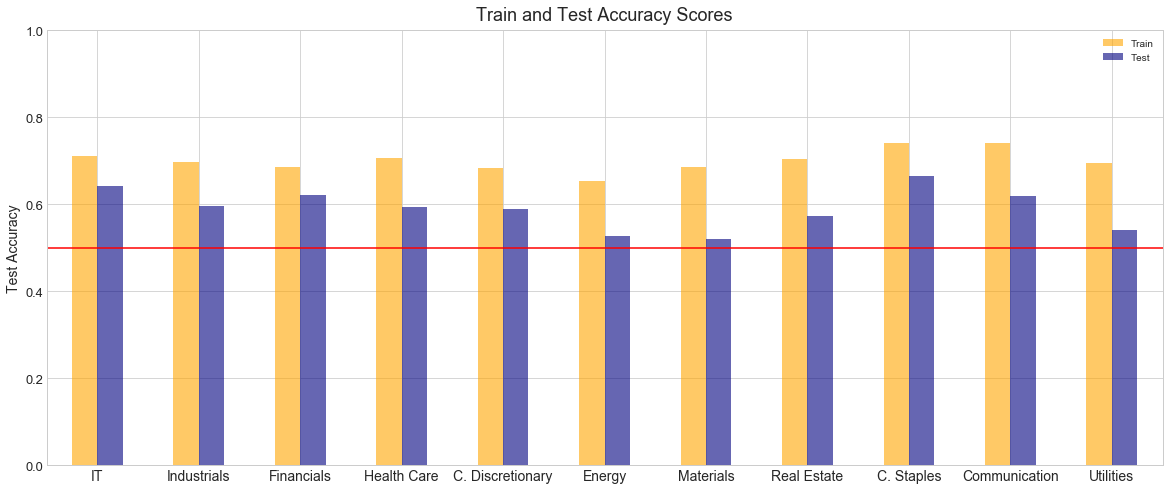

In [48]:
# Create plot fot 'Test Accuracy Scores'
results_df.plot(kind='bar', figsize=(20,8), color=['orange', 'navy'], alpha=.6)

plt.title('Train and Test Accuracy Scores', size=18, pad=10)
plt.axhline(0.5, color='r')
plt.ylabel('Test Accuracy', size=14)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],['IT', 'Industrials', 'Financials',
       'Health Care', 'C. Discretionary', 'Energy', 'Materials',
       'Real Estate', 'C. Staples', 'Communication',
       'Utilities'], size=14, rotation=0)
plt.yticks(size=13)
plt.ylim(0, 1);